In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from notebook_utils import BMW_ENCODED

📁 Проверка путей в config.py:
✅ CARS_CSV: d:\code-files\pet-projects\BimmerAI\data\bmw_parsed.csv
✅ BMW_DATA_CSV: d:\code-files\pet-projects\BimmerAI\data\bmw_preprocessed.csv
✅ BMW_PARSED: d:\code-files\pet-projects\BimmerAI\data\bmw_parsed.csv
✅ Config успешно импортирован!


In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import xgboost as xgb
from catboost import CatBoostRegressor

from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Загрузка данных

In [4]:
bmw_data = pd.read_csv(BMW_ENCODED)
bmw_data

,Серия,Поколение,Год,Рестайлинг,Пробег,Коробка,Объем,Цена,Кузов_внедорожник 5 дв.,Кузов_кабриолет,Кузов_купе,Кузов_лифтбек,Кузов_минивэн,Кузов_седан,Кузов_универсал,Кузов_хэтчбек 3 дв.,Кузов_хэтчбек 5 дв.,Топливо_бензин,Топливо_дизель
0,16909,22793,2019,0,129000,1,1.5,16999,0,0,0,0,0,0,0,0,1,0,1
1,20785,39506,2019,1,35000,2,3.0,83777,0,0,0,0,0,1,0,0,0,0,1
2,17329,6977,1999,0,400000,0,2.5,3399,0,0,0,0,0,1,0,0,0,0,1
3,18073,14777,2005,0,370000,2,2.0,7200,0,0,0,0,0,0,0,0,1,1,0
4,38953,20419,2012,1,149000,2,3.0,23450,1,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2608,16285,36902,2022,1,8540,2,3.0,59990,0,0,0,0,0,1,0,0,0,1,0
2609,39384,20419,2011,0,277000,2,3.0,22290,1,0,0,0,0,0,0,0,0,0,1
2610,17186,20288,2012,0,256000,2,3.0,23500,0,0,0,0,0,1,0,0,0,0,1
2611,39340,26879,2013,0,268500,2,2.0,21500,0,0,1,0,0,0,0,0,0,1,0


In [5]:
bmw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2613 entries, 0 to 2612
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Серия                    2613 non-null   int64  
 1   Поколение                2613 non-null   int64  
 2   Год                      2613 non-null   int64  
 3   Рестайлинг               2613 non-null   int64  
 4   Пробег                   2613 non-null   int64  
 5   Коробка                  2613 non-null   int64  
 6   Объем                    2613 non-null   float64
 7   Цена                     2613 non-null   int64  
 8   Кузов_внедорожник 5 дв.  2613 non-null   int64  
 9   Кузов_кабриолет          2613 non-null   int64  
 10  Кузов_купе               2613 non-null   int64  
 11  Кузов_лифтбек            2613 non-null   int64  
 12  Кузов_минивэн            2613 non-null   int64  
 13  Кузов_седан              2613 non-null   int64  
 14  Кузов_универсал         

# Анализ данных

,Серия,Поколение,Объем,Год
Серия,1.000000,0.641796,0.298265,0.372945
Поколение,0.641796,1.000000,0.138561,0.769473
Объем,0.298265,0.138561,1.000000,-0.153404
Год,0.372945,0.769473,-0.153404,1.000000


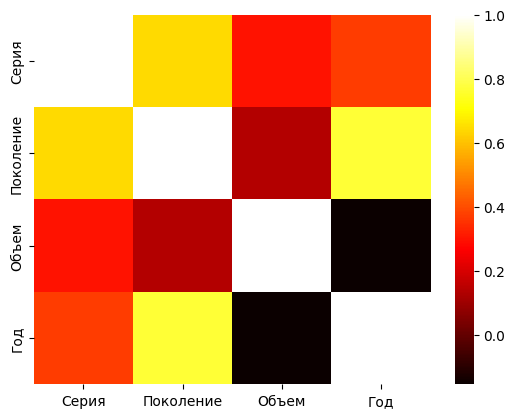

In [6]:
corr_bmw = bmw_data[["Серия", "Поколение", "Объем", "Год"]].corr()
sns.heatmap(corr_bmw, cmap="hot")
corr_bmw

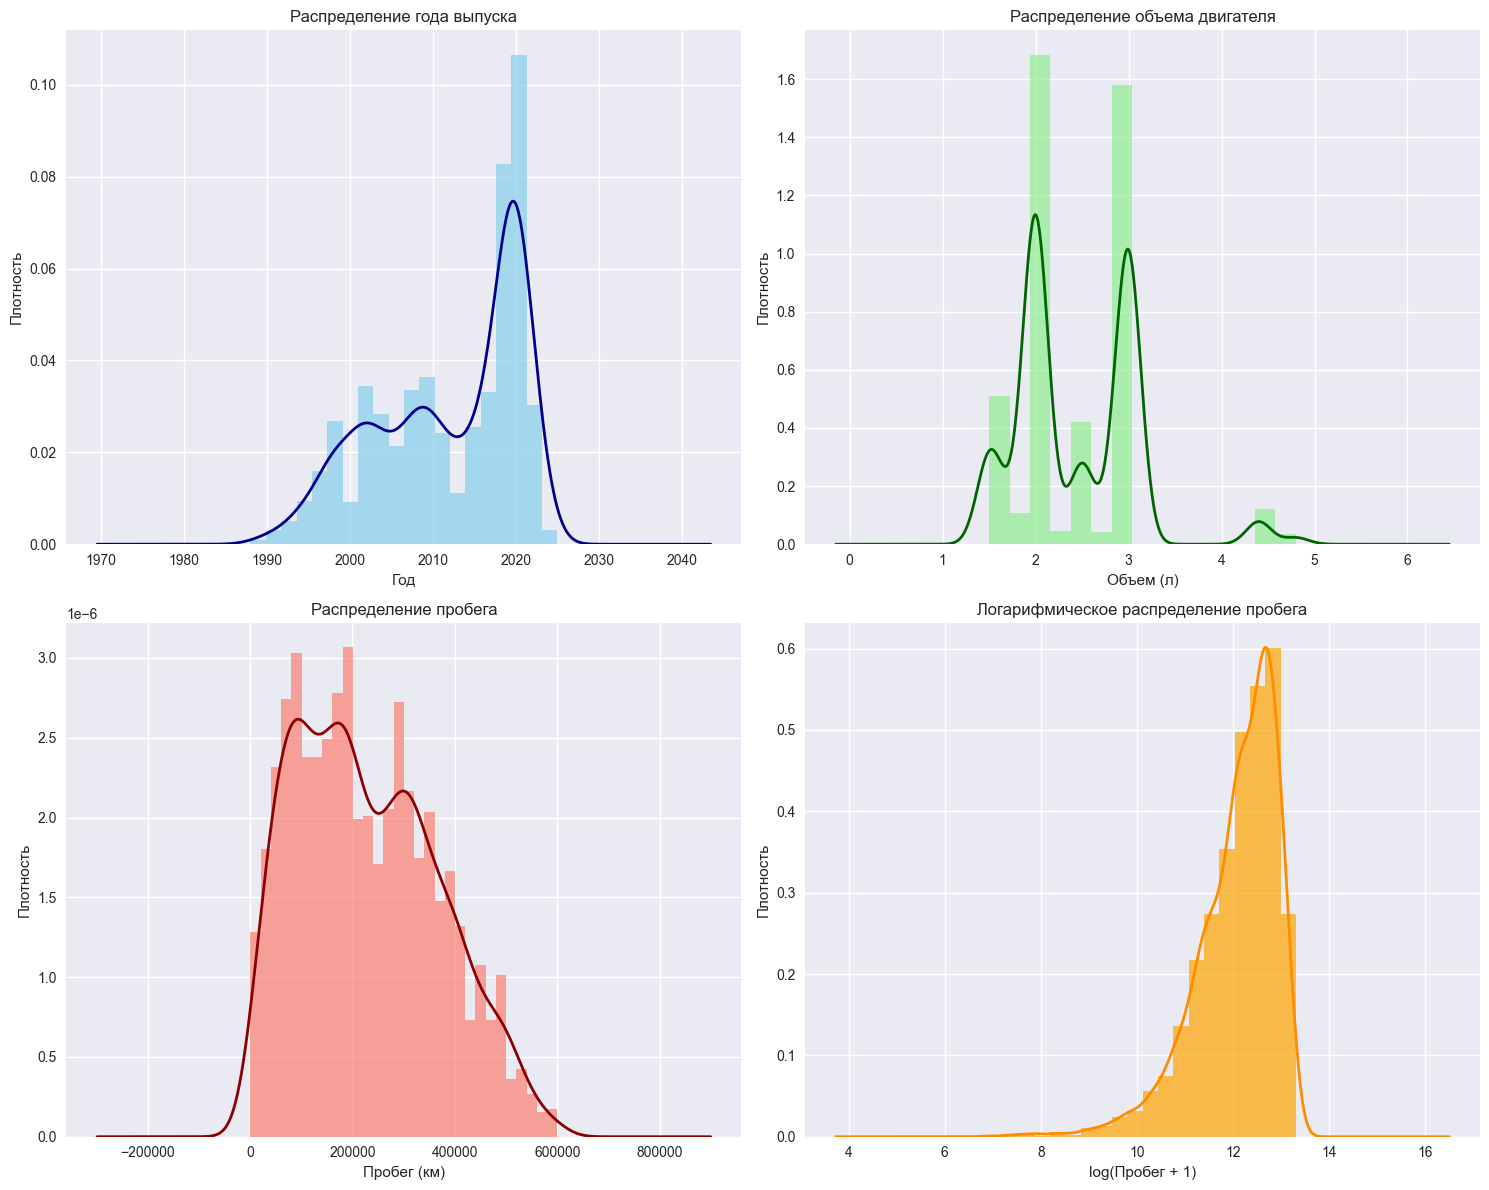

In [7]:
# Настройка стиля
plt.style.use('seaborn-v0_8')
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Год выпуска
axes[0,0].hist(bmw_data['Год'], bins=20, alpha=0.7, density=True, color='skyblue')
bmw_data['Год'].plot(kind='kde', ax=axes[0,0], color='darkblue', linewidth=2)
axes[0,0].set_title('Распределение года выпуска')
axes[0,0].set_xlabel('Год')
axes[0,0].set_ylabel('Плотность')

# Объем двигателя
axes[0,1].hist(bmw_data['Объем'], bins=15, alpha=0.7, density=True, color='lightgreen')
bmw_data['Объем'].plot(kind='kde', ax=axes[0,1], color='darkgreen', linewidth=2)
axes[0,1].set_title('Распределение объема двигателя')
axes[0,1].set_xlabel('Объем (л)')
axes[0,1].set_ylabel('Плотность')

# Пробег
axes[1,0].hist(bmw_data['Пробег'], bins=30, alpha=0.7, density=True, color='salmon')
bmw_data['Пробег'].plot(kind='kde', ax=axes[1,0], color='darkred', linewidth=2)
axes[1,0].set_title('Распределение пробега')
axes[1,0].set_xlabel('Пробег (км)')
axes[1,0].set_ylabel('Плотность')

# Логарифмированная версия пробега (если нужно)
axes[1,1].hist(np.log1p(bmw_data['Пробег']), bins=20, alpha=0.7, density=True, color='orange')
np.log1p(bmw_data['Пробег']).plot(kind='kde', ax=axes[1,1], color='darkorange', linewidth=2)
axes[1,1].set_title('Логарифмическое распределение пробега')
axes[1,1].set_xlabel('log(Пробег + 1)')
axes[1,1].set_ylabel('Плотность')

plt.tight_layout()
plt.show()

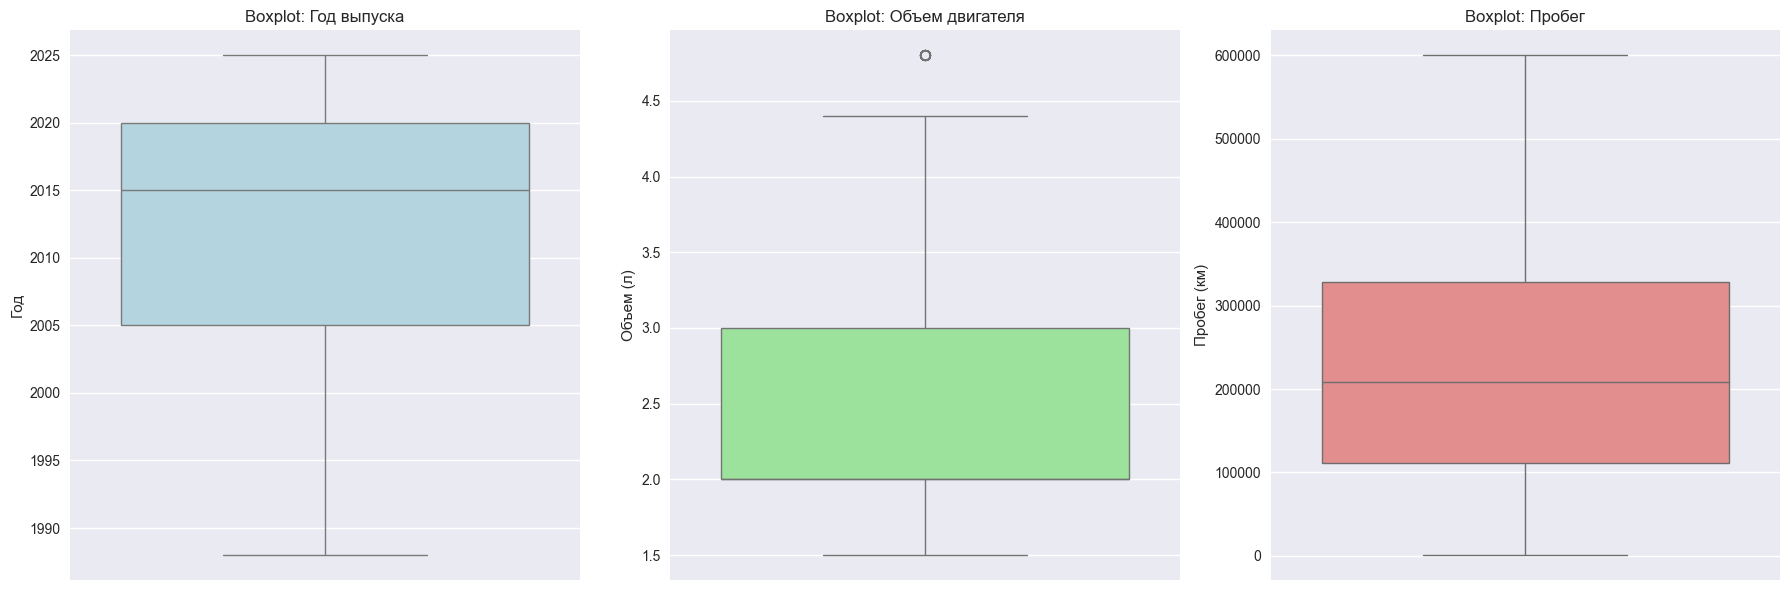

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Boxplot для года выпуска
sns.boxplot(y=bmw_data['Год'], ax=axes[0], color='lightblue')
axes[0].set_title('Boxplot: Год выпуска')
axes[0].set_ylabel('Год')

# Boxplot для объема двигателя
sns.boxplot(y=bmw_data['Объем'], ax=axes[1], color='lightgreen')
axes[1].set_title('Boxplot: Объем двигателя')
axes[1].set_ylabel('Объем (л)')

# Boxplot для пробега
sns.boxplot(y=bmw_data['Пробег'], ax=axes[2], color='lightcoral')
axes[2].set_title('Boxplot: Пробег')
axes[2].set_ylabel('Пробег (км)')

plt.tight_layout()
plt.show()

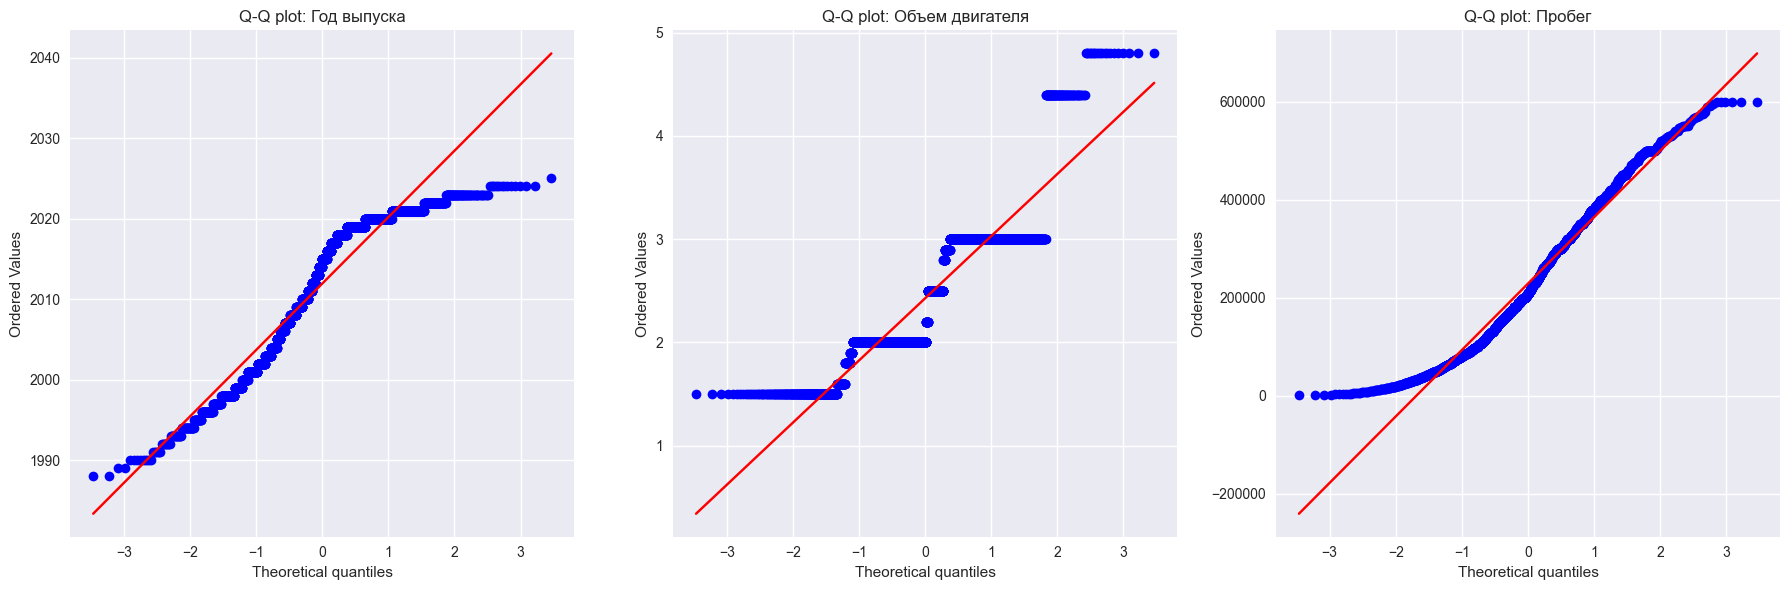

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Q-Q plot для года выпуска
stats.probplot(bmw_data['Год'], dist="norm", plot=axes[0])
axes[0].set_title('Q-Q plot: Год выпуска')

# Q-Q plot для объема двигателя
stats.probplot(bmw_data['Объем'], dist="norm", plot=axes[1])
axes[1].set_title('Q-Q plot: Объем двигателя')

# Q-Q plot для пробега
stats.probplot(bmw_data['Пробег'], dist="norm", plot=axes[2])
axes[2].set_title('Q-Q plot: Пробег')

plt.tight_layout()
plt.show()

## Конспект-теория

| Понятие       | Делит на | Уровни | Пример |
|---------------|----------|---------|---------|
| **Перцентиль** | 100 частей | 0-100% | 90-й перцентиль |
| **Квантиль**  | n частей | 0-1 | Квантиль 0.9 |
| **Квартиль**  | 4 части | Q1, Q2, Q3 | Q3 = 75-й перцентиль |

### Q-Q plot

`Q-Q plot` — это график, который показывает, как распределение данных соотносится с нормальным распределением.
- [Статья на хабре с доп. источниками для понимания этого графика](https://habr.com/ru/articles/578754)
- . . .

# Предобработка данных

## Выгрузка значений

In [10]:
X = bmw_data.drop(['Цена'], axis=1).values
X

array([[1.6909e+04, 2.2793e+04, 2.0190e+03, ..., 1.0000e+00, 0.0000e+00,
        1.0000e+00],
       [2.0785e+04, 3.9506e+04, 2.0190e+03, ..., 0.0000e+00, 0.0000e+00,
        1.0000e+00],
       [1.7329e+04, 6.9770e+03, 1.9990e+03, ..., 0.0000e+00, 0.0000e+00,
        1.0000e+00],
       ...,
       [1.7186e+04, 2.0288e+04, 2.0120e+03, ..., 0.0000e+00, 0.0000e+00,
        1.0000e+00],
       [3.9340e+04, 2.6879e+04, 2.0130e+03, ..., 0.0000e+00, 1.0000e+00,
        0.0000e+00],
       [2.1267e+04, 1.9868e+04, 2.0170e+03, ..., 0.0000e+00, 0.0000e+00,
        1.0000e+00]], shape=(2613, 18))

In [11]:
y = bmw_data['Цена'].values
y

array([16999, 83777,  3399, ..., 23500, 21500, 13000], shape=(2613,))

## Шкалирование данных

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

numeric_features_idx = [0,1,2,4] # Серия, Поколение, Год, Пробег

X_scaler = StandardScaler()
X_train_scaled = X_train[:].copy()
X_train_scaled[numeric_features_idx] = X_scaler.fit_transform(X_train[numeric_features_idx])
X_test_scaled = X_test[:].copy()
X_test_scaled[numeric_features_idx] = X_scaler.transform(X_test[numeric_features_idx])

y_scaler = StandardScaler()
y_train_scaled = y_train[:].copy()
y_train_scaled= y_scaler.fit_transform(y_train.reshape(-1, 1)).ravel()
y_test_scaled = y_test[:].copy()
y_test_scaled = y_scaler.transform(y_test.reshape(-1, 1)).ravel()

In [13]:
X_scaled = np.vstack((X_train_scaled, X_test_scaled))
print(X_scaled.shape, X.shape)

y_scaled = np.hstack((y_train_scaled, y_test_scaled))
print(y_scaled.shape, y.shape)

(2613, 18) (2613, 18)
(2613,) (2613,)


In [14]:
y_test[0], y_scaler.inverse_transform([[y_test_scaled[0]]]).ravel()[0], y_test_scaled[0]

(np.int64(92000), np.float64(92000.0), np.float64(2.956388032851558))

In [15]:
poly_ft = PolynomialFeatures(degree=2)
X_train_feat = poly_ft.fit_transform(X_train_scaled)
X_test_feat = poly_ft.fit_transform(X_test_scaled)
X_test_scaled.shape, X_test_feat.shape

((523, 18), (523, 190))

# Модели

## Линейная регрессия

In [16]:
X = bmw_data.drop(["Цена"], axis=1).values
y = bmw_data["Цена"].values

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=41)

In [18]:
model = LinearRegression()
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.856580541433752

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=41)

In [20]:
model = LinearRegression()
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.8597256636575576

In [21]:
np.array((bmw_data.drop(['Цена'], axis=1).columns.values, model.coef_)).T

array([['Серия', 4.597932414989109e-06],
       ['Поколение', 4.798755589532791e-05],
       ['Год', -0.0015798903787896663],
       ['Рестайлинг', 0.2645441706274855],
       ['Пробег', -1.230490593794022e-06],
       ['Коробка', -0.06455131161384005],
       ['Объем', 0.13868007701604976],
       ['Кузов_внедорожник 5 дв.', 1.4879778345629735],
       ['Кузов_кабриолет', 1.7506979234520448],
       ['Кузов_купе', 1.6236626003217403],
       ['Кузов_лифтбек', 1.5417848874458424],
       ['Кузов_минивэн', 1.4069497397169761],
       ['Кузов_седан', 1.6309840545603085],
       ['Кузов_универсал', 1.5445652073765084],
       ['Кузов_хэтчбек 3 дв.', 1.715125097131044],
       ['Кузов_хэтчбек 5 дв.', 1.517770908346512],
       ['Топливо_бензин', -0.9454116521389648],
       ['Топливо_дизель', -0.8298769700046177]], dtype=object)

In [22]:
poly_ft = PolynomialFeatures(degree=3)
X_poly = poly_ft.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=41)
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mean_absolute_error(y_pred, y_test), model.score(X_test, y_test)

(2897.602766940346, 0.9370604556909516)

In [23]:
scores = cross_val_score(model, X, y, cv=5)
scores

array([0.85069439, 0.88601141, 0.86863733, 0.86591306, 0.9033267 ])

In [24]:
model.predict(X_test[100:120]) - y_test[100:120]

array([  897.77339422,  1116.75163936,  -182.31656725,   376.51576378,
       -1180.50899997,  1803.31187363,  1310.86217567,   717.64610008,
        1604.3850949 ,  -808.8891482 ,  8774.87684483, -5018.57703389,
        5114.75471478, -1414.6495625 ,  -378.72378533, -1593.08106117,
        1817.16786547,  1833.88487094,  2153.75042406,  1958.76973381])

In [25]:
model = LinearRegression()
cross_val_score(model, X_scaled, y_scaled).mean(), cross_val_score(model, X, y).mean()

(np.float64(0.8651156286068173), np.float64(0.8749165775738861))

## Дерево решений

In [26]:
X = bmw_data.drop(["Цена"], axis=1).values
y = bmw_data["Цена"].values

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=41)

In [28]:
model = DecisionTreeRegressor()
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.9077374128790343

In [29]:
poly_ft = PolynomialFeatures(degree=2)
X_poly = poly_ft.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=41)
model = DecisionTreeRegressor()
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.8957023544339447

In [30]:
scores = cross_val_score(model, X, y, cv=5)
scores

array([0.91297251, 0.92632976, 0.92280564, 0.89562226, 0.91982565])

In [31]:
model.predict(X_test[100:120]) - y_test[100:120]

array([ 6700., -2300., -2450.,   800.,   350., 12300.,  -500.,   -70.,
        3500., -1400.,  5490., -5200.,  6901., -9600.,  1000.,   800.,
        4001.,  6550.,  2300., -2277.])

In [32]:
np.array((model.predict(X_test[100:120]), y_test[100:120])).T

array([[55500., 48800.],
       [ 3500.,  5800.],
       [41500., 43950.],
       [ 5000.,  4200.],
       [ 6350.,  6000.],
       [34000., 21700.],
       [ 4000.,  4500.],
       [18900., 18970.],
       [16000., 12500.],
       [11500., 12900.],
       [58490., 53000.],
       [32800., 38000.],
       [79900., 72999.],
       [39900., 49500.],
       [16000., 15000.],
       [24300., 23500.],
       [44000., 39999.],
       [25550., 19000.],
       [12300., 10000.],
       [41500., 43777.]])

## Градиентный бустинг

### `sklearn`

In [33]:
model = GradientBoostingRegressor(
    n_estimators=150,
    learning_rate=0.15,
    max_depth=4,
    random_state=43
)

cross_val_score(model, X, y)

array([0.95581408, 0.95153697, 0.95239372, 0.93253232, 0.93389776])

In [34]:
model.fit(X_train, y_train)
model.score(X_test, y_test) 

0.941728172550799

Text(0.5, 1.0, 'Distribution of residuals')

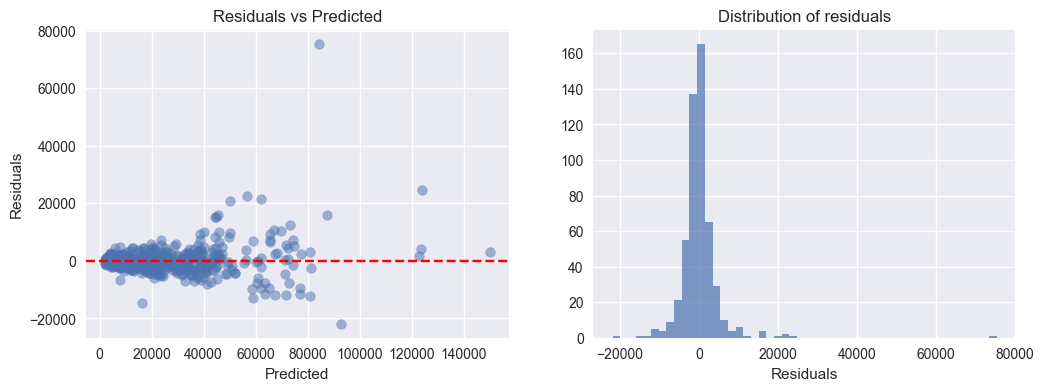

In [35]:
y_pred = model.predict(X_test)
residuals = y_test - y_pred

plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted')

plt.subplot(122)
plt.hist(residuals, bins=50, alpha=0.7)
plt.xlabel('Residuals')
plt.title('Distribution of residuals')

### `xgboost`

In [36]:
# Подготовка данных
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Создание DMatrix (оптимизированный формат для XGBoost)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Параметры
params = {
    'max_depth': 6,
    'eta': 0.3,  # learning rate
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse'
}

# Обучение
model = xgb.train(params, dtrain, num_boost_round=30)

# Предсказание
y_pred = model.predict(dtest)
mean_absolute_error(y_test, y_pred), r2_score(y_test, y_pred)

(2898.097900390625, 0.9414310455322266)

### `catboost`

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [38]:
model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.1,
    depth=6,
    verbose=0,
    allow_writing_files=False
)

model.fit(X_train, y_train, eval_set=(X_test, y_test))
y_pred = model.predict(X_test)

mean_absolute_error(y_test, y_pred), r2_score(y_test, y_pred)

(2774.024420684951, 0.9528952621239295)

# Итоги

🎯 **Итоги работы на текущий момент**

✅ **Плюсы и достижения** 

1. 🚀 **Быстрое прототипирование**
+ 📊 На скорую руку преобразовали категориальные и числовые признаки с помощью `encoder`'ов `sklearn` 
+ 🤖 Быстро получили обученные модели с хорошим `r2_score = 0.86`
+ ⚡ Простая workflow: `import` → `обучение` → `готово!`

2. 📈 **Хорошие метрики качества**
*R² Score:* 0.85-0.95 ✅


⚠️ **Минусы и проблемы**

1. 💸 **Высокая ошибка предсказаний**
- 🎯 **MAE = 3000$** - это достаточно много для практического применения
- 🚗 На эти деньги можно купить:
  - *Гнилушку-БэМэВушку* 
  - **Целых 6 Жигулей!** 🚙🚙🚙🚙🚙🚙

2. 📉 **Проблемы с фичами**
- 🎭 Некоторые признаки были созданы "по приколу" 🤡
- ❌ Странное поведение ключевых признаков:
  - `Пробег` - незначительное влияние
  - `Год` - отрицательный коэффициент (подозрительно!)
  - `Серия`/`Поколение` - минимальный вклад

🛠️ **Рекомендации по улучшению от GPT**

🔍 **1. Анализ ошибок**
 - Детальный анализ где ошибается модель

🎨 **2. Улучшение feature engineering**
- Создавать **осмысленные признаки** на доменных знаниях
- Добавить **взаимодействия признаков** 
- Использовать **групповые статистики**

🧹 **3. Работа с выбросами**
- Обработка выбросов в целевой переменной

⚙️ **4. Тщательная настройка гиперпараметров**
- GridSearch/RandomizedSearch для оптимизации
- Использовать кросс-валидацию
- Настроить регуляризацию

🤝 **5. Ансамблирование моделей**
- Комбинирование нескольких алгоритмов

🔄 **6. Эксперименты с преобразованием целевой переменной**
- Логарифмирование: `np.log1p(y)`
- Box-Cox преобразование
- Квантильное преобразование


📊 **Ожидаемый результат**
При реализации рекомендаций можно достичь:
- **MAE снизится с 3000$ до 1000-1500$** 🎯
- **Улучшится интерпретируемость** модели
- **Возрастет практическая полезность** прогнозов

> 💡 *Следующие шаги: начать с анализа ошибок и feature engineering!*

# 📊 Коэффициенты линейной регрессии

## 🔍 Общая информация

После применения `StandardScaler` к числовым признакам, коэффициенты показывают:  
**"На сколько долларов изменится цена при изменении признака на 1 стандартное отклонение"**

## 📋 Таблица коэффициентов

| Признак | Коэффициент | Интерпретация | Статус |
|---------|-------------|---------------|---------|
| **Кузов_кабриолет** | 1.739 | 🔼 +1739$ относительно базового кузова | ✅ Логично |
| **Кузов_хэтчбек 3 дв.** | 1.714 | 🔼 +1714$ относительно базового кузова | ✅ Логично |
| **Кузов_седан** | 1.634 | 🔼 +1634$ относительно базового кузова | ✅ Логично |
| **Кузов_купе** | 1.621 | 🔼 +1621$ относительно базового кузова | ✅ Логично |
| **Кузов_универсал** | 1.550 | 🔼 +1550$ относительно базового кузова | ✅ Логично |
| **Кузов_лифтбек** | 1.548 | 🔼 +1548$ относительно базового кузова | ✅ Логично |
| **Кузов_хэтчбек 5 дв.** | 1.523 | 🔼 +1523$ относительно базового кузова | ✅ Логично |
| **Кузов_внедорожник 5 дв.** | 1.490 | 🔼 +1490$ относительно базового кузова | ✅ Логично |
| **Кузов_минивэн** | 1.411 | 🔼 +1411$ относительно базового кузова | ✅ Логично |
| **Рестайлинг** | 0.265 | 🔼 +265$ при наличии рестайлинга | ✅ Логично |
| **Объем** | 0.138 | 🔼 +0.14$ при увеличении объема на 1 ст. отклонение | ⚠️ Мало |
| **Топливо_бензин** | -1.173 | 🔽 -1173$ относительно базового топлива | 🔍 Нужна инфа |
| **Топливо_дизель** | -1.062 | 🔽 -1062$ относительно базового топлива | 🔍 Нужна инфа |
| **Коробка** | -0.065 | 🔽 -65$ | 🔍 Зависит от кодировки |
| **Год** | -0.0015 | 🔽 -1.5$ при увеличении года на 1 ст. отклонение | ❌ Подозрительно |
| **Поколение** | 4.79e-05 | ➡️ Практически нулевое влияние | ⚠️ Бесполезен |
| **Серия** | 4.97e-06 | ➡️ Практически нулевое влияние | ⚠️ Бесполезен |
| **Пробег** | -1.21e-06 | 🔽 Ничтожно малое влияние | ⚠️ Бесполезен |

## 💡 Ключевые insights

### ✅ **Что работает хорошо:**
- **Тип кузова** имеет сильное и логичное влияние на цену
- **Рестайлинг** увеличивает цену на 265$ - разумно
- **Объем двигателя** влияет положительно, но слабо

### ⚠️ **Проблемные зоны:**
- **Год выпуска** имеет отрицательный коэффициент ❌
  - *Ожидалось:* новее = дороже
  - *Получилось:* новее = дешевле
- **Пробег** практически не влияет на цену 🤔
- **Серия и Поколение** бесполезны в текущем виде

### 🔍 **Требуют investigation:**
- **Базовый тип кузова** (удален из-за dummy variable trap)
- **Базовый тип топлива** (вероятно, гибрид/электро)
- **Кодировка коробки передач**

## 🛠️ Рекомендации по улучшению

1. **Проверить мультиколлинеарность** 📈
   - Возможно, признаки скоррелированы между собой
   
2. **Исследовать аномалии** 🔍
   - Почему год имеет отрицательный коэффициент?
   - Почему пробег не влияет на цену?

3. **Удалить бесполезные признаки** 🗑️
   - Серия и Поколение практически не влияют

4. **Пересмотреть feature engineering** 🎨
   - Возможно, нужны другие преобразования признаков

> 💭 **Вывод:** Модель имеет потенциал, но требует доработки и анализа данных!
```

Средние цены на автомобили BMW в зависимости от кузова:

<img src="../../images/car_body_prices.png" width="600" alt="Гистограмма цен на разные кузова">

Влияние типов кузова на цену по "мнению" построенной модели линейной регрессии:
| Признак | Коэффициент |
|---------|-------------|
| **Кузов_кабриолет** | 1.739 |
| **Кузов_хэтчбек 3 дв.** | 1.714 |
| **Кузов_седан** | 1.634 | 
| **Кузов_купе** | 1.621 | 
| **Кузов_универсал** | 1.550 | 
| **Кузов_лифтбек** | 1.548 | 
| **Кузов_хэтчбек 5 дв.** | 1.523 |
| **Кузов_внедорожник 5 дв.** | 1.490 |
| **Кузов_минивэн** | 1.411 | 

***Мораль:***
- Имееются несостыковочки, значит не все так просто, как я думал :(

- В процессе анализа уже было замечено, что куда более информативны комбинации из характеристик объявления, а не характеристики по отдельности.

- Например, старый и новый седаны будут сильно отличаться в цене, но и новый седан с огромным пробегом (б\у автомобиль такси) будет иметь сниженную цену, так что нужно создать совокупный признак `кузов-пробег-год_издания`, который в одиночку будет являться более информативным, чем перечисленные по одиночке.